In [2]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from time import perf_counter


# Define the preprocessing and pipeline functions
ord_cols = {
    'FURNISH': ['unfurnished', 'semifurnished', 'furnished'], 
    "AGE": ['under construction', '0-1 year old property', '1-5 year old property', 
            '5-10 year old property', '10+ year old property'], 
    "BEDROOM_NUM": sorted([2.0, 3.0, 1.0, 5.0, 4.0, 99.0]),  
    "BALCONY_NUM": sorted([1.0, 2.0, 3.0, 0.0, 4.0, 99.0]),   
    "FLOOR_NUM": ['low rise', 'mid rise', 'high rise'],  
}

ohe_cols = ["FACING", "LOCALITY_NAME"]

preprocessor = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(categories=list(ord_cols.values())), list(ord_cols.keys())),
        ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ohe_cols),
        ("log1p_area", FunctionTransformer(np.log1p, np.expm1, validate=True), ["AREA"]),
    ],
    remainder="passthrough",
)

# Load data and preprocess it
df = pd.read_csv('data/processed/mumbai/res_apartment_dataset.csv')

target = "PRICE"
num_cols = ['AREA', 'BEDROOM_NUM', 'BALCONY_NUM', 'FLOOR_NUM']
cat_cols = ['FURNISH', 'AGE', 'FACING', 'LOCALITY_NAME']

main_df = df[[target] + num_cols + cat_cols].copy(True)

# Apply additional transformations
main_df["BEDROOM_NUM"] = main_df["BEDROOM_NUM"].apply(lambda x: x if x <= 5 else 99)
main_df["BALCONY_NUM"] = main_df["BALCONY_NUM"].apply(lambda x: x if x <= 4 else 99)

# Prepare the feature matrix X and target vector y
X = main_df.drop(columns=[target])
y = pd.Series(np.log1p(main_df[target]), name="PRICE")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Function to calculate MAE score
def calc_scores(y_true, y_pred):
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)

    mae = mean_absolute_error(y_true, y_pred) / 100000  # Assuming 1 Lakh scale
    return mae


# Function to create model pipeline
def create_model_pipe(estimator, preprocessor: ColumnTransformer | None):
    return Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("scaler", StandardScaler()),
            ("model", estimator),
        ]
    )


# Model dictionary and estimator
models_dict = {
    "rf_500": RandomForestRegressor(n_estimators=500)
}


# Function to save the pipeline model
def save_pipeline_model(pipeline_model, filename="pipeline.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(pipeline_model, f)
    print(f"Pipeline model saved as {filename}")


# Function to save the DataFrame
def save_dataframe(df, filename="df.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(df, f)
    print(f"DataFrame saved as {filename}")


# Function to calculate cross-validation scores and model performance
def calc_cv_score(X_train, y_train, *, X_test=None, y_test=None) -> dict:
    scores_dict = {}

    if X_test is None or y_test is None:
        X_test = X_train
        y_test = y_train

    for name, estimator in models_dict.items():
        start_time = perf_counter()
        scores = cross_val_score(
            model := create_model_pipe(estimator, preprocessor),
            X_train,
            y_train,
            cv=5,
            scoring="r2",
        )

        print(f"Fitting `{name}` model with {scores.mean():.3} R2 score.")
        model.fit(X_train, y_train)
        
        # Save the trained model using pickle
        model_filename = f"{name}_model.pkl"
        with open(model_filename, "wb") as file:
            pickle.dump(model, file)
        print(f"Saved `{name}` model to {model_filename}")
        
        scores_dict[name] = {
            "r2_mean": scores.mean(),
            "r2_std": scores.std(),
            "mae": calc_scores(y_test, model.predict(X_test)),
        }
        print(f"{name} model takes {(perf_counter() - start_time):.3} seconds.\n")

        # Save pipeline model and dataframe
        save_pipeline_model(model, "pipeline.pkl")  # Save the trained model pipeline
        save_dataframe(X_train, "df.pkl")  # Save the X_train DataFrame

    return scores_dict


# Train the model and evaluate its performance
scores_dict = calc_cv_score(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
print(pd.DataFrame.from_dict(scores_dict, "index").sort_values("mae").round(3))


C:\Users\Paresh Gupta\Desktop\DSLAB\dslab\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Paresh Gupta\Desktop\DSLAB\dslab\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Paresh Gupta\Desktop\DSLAB\dslab\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Paresh Gupta\Desktop\DSLAB\dslab\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
C:\Users\Paresh Gupta\Desktop\DSLAB\dslab\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature nam

Fitting `rf_500` model with 0.911 R2 score.


C:\Users\Paresh Gupta\Desktop\DSLAB\dslab\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


Saved `rf_500` model to rf_500_model.pkl
rf_500 model takes 1.92e+02 seconds.

Pipeline model saved as pipeline.pkl
DataFrame saved as df.pkl
        r2_mean  r2_std     mae
rf_500    0.911   0.011  40.674


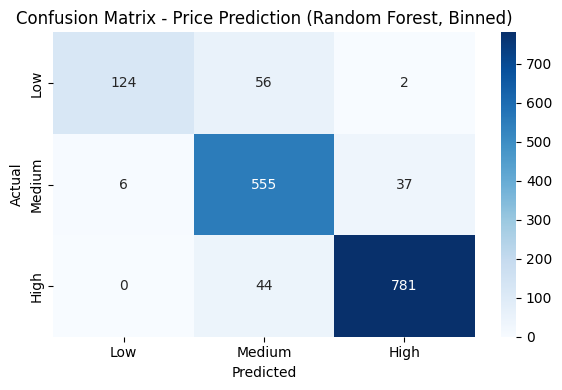

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Get model and make predictions
with open("pipeline.pkl", "rb") as f:
    pipeline_model = pickle.load(f)

# Predict on test data
y_pred_log = pipeline_model.predict(X_test)
y_true_price = np.expm1(y_test)
y_pred_price = np.expm1(y_pred_log)

# Step 2: Define binning function
def price_category(price):
    if price < 50_00_000:
        return "Low"
    elif price <= 1_50_00_000:
        return "Medium"
    else:
        return "High"

# Step 3: Apply binning
y_true_cat = pd.Series(y_true_price).apply(price_category)
y_pred_cat = pd.Series(y_pred_price).apply(price_category)

# Step 4: Confusion matrix
labels = ["Low", "Medium", "High"]
cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels)

# Step 5: Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Price Prediction (Random Forest, Binned)")
plt.tight_layout()
plt.show()

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Labels used for classification
labels = ["Low", "Medium", "High"]

# Accuracy
accuracy = accuracy_score(y_true_cat, y_pred_cat)

# Precision, Recall, F1 (macro handles multi-class averaging)
precision = precision_score(y_true_cat, y_pred_cat, average='macro')
recall = recall_score(y_true_cat, y_pred_cat, average='macro')
f1 = f1_score(y_true_cat, y_pred_cat, average='macro')

print("=== Classification Metrics ===")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")

# Optional: Full classification report
print("\nFull Classification Report:")
print(classification_report(y_true_cat, y_pred_cat, target_names=labels))


=== Classification Metrics ===
Accuracy : 0.910
Precision: 0.918
Recall   : 0.852
F1 Score : 0.877

Full Classification Report:
              precision    recall  f1-score   support

         Low       0.95      0.95      0.95       825
      Medium       0.95      0.68      0.79       182
        High       0.85      0.93      0.89       598

    accuracy                           0.91      1605
   macro avg       0.92      0.85      0.88      1605
weighted avg       0.91      0.91      0.91      1605

